In [1]:
import pandas as pd
import sqlite3
import requests
import numpy as np
import folium
import folium.plugins 
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Data for the RV grouping project

Online I found a complete list of camp grounds in CSV format from http://www.poi-factory.com/node/17657

I will now extract all the required information
- Latitude and Longitude Data
- Name of the Camp Site
- Save the data to a sql3 database for wasy retreival and querying

# Loading data

In [2]:
df_raw = pd.read_csv('ParksandCampsites.csv', header=None)

# Writing the campsite data to a sqlite3 database

In [4]:
con = sqlite3.connect('Campsite_data_4k-all.db')
try:
    df_raw.to_sql('Sites',con)
except:
    pass
con.close()

In [5]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT Campsite_Name, Latitude, Longitude FROM Sites WHERE Campsite_Name not like '%closed%'   '''
df_RV = pd.read_sql_query(query,con).set_index('Campsite_Name').drop_duplicates()
con.close
df_RV


,Latitude,Longitude
Campsite_Name,,
'KSAN Historical Village Campground,55.249428,-127.679933
10 Acres Campground and RV Park,44.030277,-73.403468
1000 Islands Campground,44.276788,-75.997158
1000 Islands Camping Resort,44.350050,-76.054170
1000 Islands/Association Island K O A,43.891877,-76.216943
...,...,...
Zippel Bay SP,48.847923,-94.849806
Zooland Family Campground,35.603549,-79.850677
Zumbro Bottoms Horse Campground,44.301126,-92.122085


# The foursquare API setting

In [ ]:
CLIENT_ID = 'XX' # your Foursquare ID
CLIENT_SECRET = 'XX' # your Foursquare Secret
ACCESS_TOKEN = 'XX' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 60
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

## Neighboring venues data

Now I will use Foursquare to download neighboring venue data and save them to my sql3 database

In [7]:
try:
    con = sqlite3.connect('Campsite_data_4k-all.db')
    query = ''' SELECT distinct(Campsite_Name) FROM Venues'''
    completed_venues = pd.read_sql_query(query,con)['Campsite_Name'].tolist()
    con.close
except:
    completed_venues = []

num_iter = 0
print('Number of completed venues that will not be run again: {}'.format(len(completed_venues)))
for key, item in df_RV.reset_index().iterrows():
    clear_output(wait=True)
    venues_list = []
    num_iter = num_iter +1
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        item['Latitude'], 
        item['Longitude'], 
        4000, #radius
        LIMIT)
    
    if not (item['Campsite_Name'] in completed_venues):
        print('Number: {}, New Site: {}'.format(num_iter,item['Campsite_Name']))
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            for v in results:
                temp = {}
                temp['Campsite_Name']= item['Campsite_Name']
                temp['Latitude']= item['Latitude']
                temp['Longitude']= item['Longitude']
                temp['Venue']=v['venue']['name']
                temp['Venue_Latitude']=v['venue']['location']['lat']
                temp['Venue_Longitude']=v['venue']['location']['lng']  
                temp['Venue_Category']=v['venue']['categories'][0]['name']
                venues_list.append(temp)

            nearby_venues = pd.DataFrame(venues_list)
            con = sqlite3.connect('Campsite_data_4k-all.db')
            nearby_venues.to_sql('Venues',con,if_exists='append')
            con.close()
        except:
            print('Failed')

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Check data integrity

In [8]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT * FROM Venues'''
completed_venues = pd.read_sql_query(query,con).drop('index',axis=1)
completed_venues

,Campsite_Name,Latitude,Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,'KSAN Historical Village Campground,55.249428,-127.679933,Ksan Historical Village,55.250044,-127.677005,Gift Shop
1,'KSAN Historical Village Campground,55.249428,-127.679933,'Ksan Historic Village and Museum,55.251827,-127.674639,Museum
2,'KSAN Historical Village Campground,55.249428,-127.679933,Polly's Cafe,55.255564,-127.675666,Café
3,'KSAN Historical Village Campground,55.249428,-127.679933,Polly Sargent Park,55.256735,-127.676958,Park
4,'KSAN Historical Village Campground,55.249428,-127.679933,Gitanmaax Market,55.257602,-127.662515,Market
...,...,...,...,...,...,...,...
146383,Travelers N Park and Campground,31.751306,-98.921703,Jerrys Burgers N Shakes,31.744784,-98.940153,American Restaurant
146384,Travelers N Park and Campground,31.751306,-98.921703,Burger King,31.737710,-98.957946,Fast Food Restaurant
146385,Travelers N Park and Campground,31.751306,-98.921703,ACE DISPOSAL,31.780158,-98.913099,Business Service
146386,Travelers N Park and Campground,31.751306,-98.921703,Happy China Buffet,31.736954,-98.954941,Chinese Restaurant


# The Kmeans model

In [1]:
import pandas as pd
import sqlite3
import requests
import numpy as np
import folium
import folium.plugins 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### We will now read the data, generate a dummy variable dataframe which we will use for the analysis

In [2]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT * FROM Venues'''
completed_venues = pd.read_sql_query(query,con).drop('index',axis=1)
query = ''' SELECT Campsite_Name, Latitude, Longitude FROM Sites WHERE Campsite_Name not like '%closed%'   '''
df_RV = pd.read_sql_query(query,con).drop_duplicates()
con.close()
Camp_sites_onehot = pd.get_dummies(completed_venues[['Venue_Category']], prefix="", prefix_sep="")
Camp_sites_onehot['Latitude'] = completed_venues['Latitude']
Camp_sites_onehot = Camp_sites_onehot[[Camp_sites_onehot.columns[-1]] + list(Camp_sites_onehot.columns[:-1])]
campsite_grouped = Camp_sites_onehot.groupby('Latitude').mean().reset_index()
campsite_grouped_clustering = campsite_grouped.drop('Latitude', 1)
campsite_grouped

,Latitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,19.136683,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19.501292,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.734633,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.026883,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21.071786,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,64.962006,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9041,64.997376,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9042,65.053898,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9043,65.825600,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
result_ss = []


range_for_test = list(range(4,20))

# run k-means clustering
for k in range_for_test:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(campsite_grouped_clustering)
    result_ss.append(kmeans.inertia_)

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [41]:
start = range_for_test[0]
range_test_stats = []
for instance in result_ss:
    temp = {}
    temp['Clusters'] = start 
    temp['SSD'] = instance
    range_test_stats.append(temp)
    start = start +1
df_range_test_stats = pd.DataFrame(range_test_stats)

In [46]:
con = sqlite3.connect('Campsite_data_4k-all.db')
df_range_test_stats.to_sql('KmeansE',con,if_exists='replace')
con.close()

### Let's plot the squared means distances generated by the array of clusters

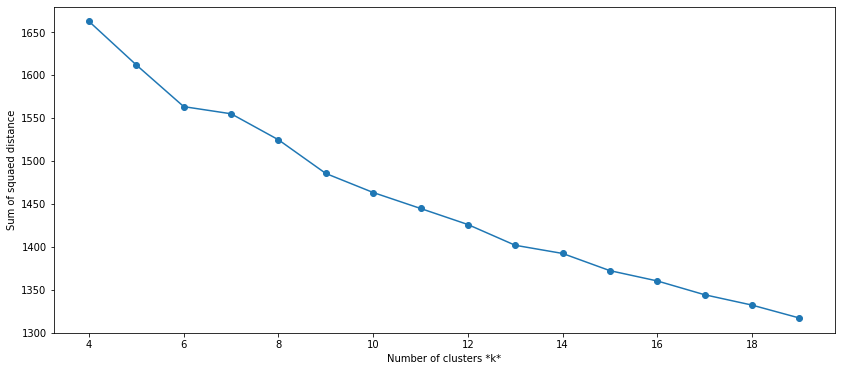

In [18]:
plt.figure(figsize=(14,6))
plt.plot(range_for_test,result_ss, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squaed distance')
plt.savefig('Kmeans_elbow.png',dpi=300)
plt.show()

### The elbow plot shows that 6 clusters is the optimum amount

In [6]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(campsite_grouped_clustering)

In [7]:
kmeans.labels_[0:30]

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [8]:
campsite_grouped.insert(0, 'Kmeans_Cluster_Labels', kmeans.labels_)
df_RV = df_RV.reset_index().set_index('Latitude')
campsite_grouped = campsite_grouped.set_index('Latitude')

In [9]:
df_RV['Kmeans_Cluster_Labels'] = campsite_grouped['Kmeans_Cluster_Labels']
df_RV = df_RV.reset_index()
df_RV

,Latitude,index,Campsite_Name,Longitude,Kmeans_Cluster_Labels
0,55.249428,0,'KSAN Historical Village Campground,-127.679933,1.0
1,44.030277,1,10 Acres Campground and RV Park,-73.403468,1.0
2,44.276788,2,1000 Islands Campground,-75.997158,1.0
3,44.350050,3,1000 Islands Camping Resort,-76.054170,0.0
4,43.891877,4,1000 Islands/Association Island K O A,-76.216943,1.0
...,...,...,...,...,...
16971,48.847923,16972,Zippel Bay SP,-94.849806,NaN
16972,35.603549,16973,Zooland Family Campground,-79.850677,NaN
16973,44.301126,16974,Zumbro Bottoms Horse Campground,-92.122085,NaN
16974,35.224768,16975,Zuni Village RV Park,-114.014515,NaN


In [10]:
df_RV.groupby('Kmeans_Cluster_Labels').count()

,Latitude,index,Campsite_Name,Longitude
Kmeans_Cluster_Labels,,,,
0.0,1194,1194,1194,1194
1.0,6332,6332,6332,6332
2.0,431,431,431,431
3.0,501,501,501,501
4.0,351,351,351,351
5.0,258,258,258,258


## Let's generate the maps for the different groups

In [ ]:
# create map of RV parks using latitude and longitude values
latitude = df_RV['Latitude'].mean()
longitude = df_RV['Longitude'].mean()
map_national_RV_parks_clusters = {}
for cluster in df_RV.groupby('Kmeans_Cluster_Labels').count().reset_index()['Kmeans_Cluster_Labels'].tolist():
    
    map_national_RV_parks_clusters[cluster] = folium.Map(location=[latitude, longitude], zoom_start=4)

    # add markers to map
    marker_cluster_clusters = {}
    marker_cluster_clusters[cluster] = folium.plugins.MarkerCluster().add_to(map_national_RV_parks_clusters[cluster])
    for lat, lng, name in zip(df_RV[df_RV['Kmeans_Cluster_Labels']==cluster]['Latitude'], df_RV[df_RV['Kmeans_Cluster_Labels']==cluster]['Longitude'], df_RV.reset_index()[df_RV['Kmeans_Cluster_Labels']==cluster]['Campsite_Name']):
        label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
        #label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster_clusters[cluster])  

    map_national_RV_parks_clusters[cluster].save('Kmeans/Cluster_{}.html'.format(int(cluster)))

In [12]:
df_RV = df_RV.drop('index',axis=1)

In [19]:
con = sqlite3.connect('Campsite_data_4k-all.db')
df_RV.to_sql('Kmeans',con,if_exists='replace')
campsite_grouped.reset_index().to_sql('Kmeans_grouped',con,if_exists='replace')
con.close()

/home/theia/.local/lib/python3.6/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


## Let's generate the top 10 lists

In [27]:
range_i = list(range(1,campsite_grouped['Kmeans_Cluster_Labels'].max()+2))
df_clusters = []
df_clusters_stats = []
top_ten = []
for cluster in range_i:
    df_clusters.append(campsite_grouped[campsite_grouped['Kmeans_Cluster_Labels'] == cluster-1])
    cols = (df_clusters[-1] != 0).any()
    df_clusters[-1] = df_clusters[-1][cols[cols].index]
    try:
        df_clusters_stats.append(df_clusters[-1].drop(['Kmeans_Cluster_Labels'],1).describe().T.sort_values(by='mean', ascending=False))
    except:
        df_clusters_stats.append(df_clusters[-1].describe().T.sort_values(by='mean', ascending=False))
    temp = {}
    temp['name'] = 'Cluster {}'.format(cluster-1)
    lo = 0
    for top in df_clusters_stats[-1].iloc[:10].reset_index()['index'].tolist():
        lo = lo+1
        temp[str(lo)] = top
    top_ten.append(temp)
    print(cluster)
df_top_ten = pd.DataFrame(top_ten).set_index(['name'])
df_top_ten

1
2
3
4
5
6


,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Lake,Park,State / Provincial Park,Beach,Scenic Lookout,American Restaurant,Convenience Store,Harbor / Marina,Golf Course
Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Gas Station,Pizza Place,Sandwich Place,Discount Store,Grocery Store,Coffee Shop
Cluster 2,Trail,Campground,Scenic Lookout,State / Provincial Park,Lake,Park,Mountain,National Park,American Restaurant,Beach
Cluster 3,Construction & Landscaping,Campground,Home Service,Lake,Business Service,Golf Course,Gas Station,Restaurant,Grocery Store,Trail
Cluster 4,Lake,Campground,State / Provincial Park,Harbor / Marina,American Restaurant,Convenience Store,Park,Scenic Lookout,Golf Course,Beach
Cluster 5,Campground,Lake,Home Service,Trail,State / Provincial Park,Construction & Landscaping,Boat or Ferry,Beach,Hotel,Diner


In [29]:
con = sqlite3.connect('Campsite_data_4k-all.db')
df_top_ten.reset_index().to_sql('Kmeans_top_ten',con,if_exists='replace')
con.close()

# The Hierarchical model

In [1]:
import pandas as pd
import sqlite3
import requests
import numpy as np
import folium
import folium.plugins 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [2]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT * FROM Venues'''
completed_venues = pd.read_sql_query(query,con).drop('index',axis=1)
query = ''' SELECT Campsite_Name, Latitude, Longitude FROM Sites WHERE Campsite_Name not like '%closed%'   '''
df_RV = pd.read_sql_query(query,con).drop_duplicates()
con.close()
Camp_sites_onehot = pd.get_dummies(completed_venues[['Venue_Category']], prefix="", prefix_sep="")
Camp_sites_onehot['Latitude'] = completed_venues['Latitude']
Camp_sites_onehot = Camp_sites_onehot[[Camp_sites_onehot.columns[-1]] + list(Camp_sites_onehot.columns[:-1])]
campsite_grouped = Camp_sites_onehot.groupby('Latitude').mean().reset_index()
campsite_grouped_clustering = campsite_grouped.drop('Latitude', 1)
campsite_grouped

,Latitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,19.136683,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19.501292,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.734633,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.026883,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21.071786,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,64.962006,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9041,64.997376,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9042,65.053898,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9043,65.825600,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Builind of the model

In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=6)

In [5]:
model = model.fit(campsite_grouped_clustering)

In [6]:
model_show = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(campsite_grouped_clustering)

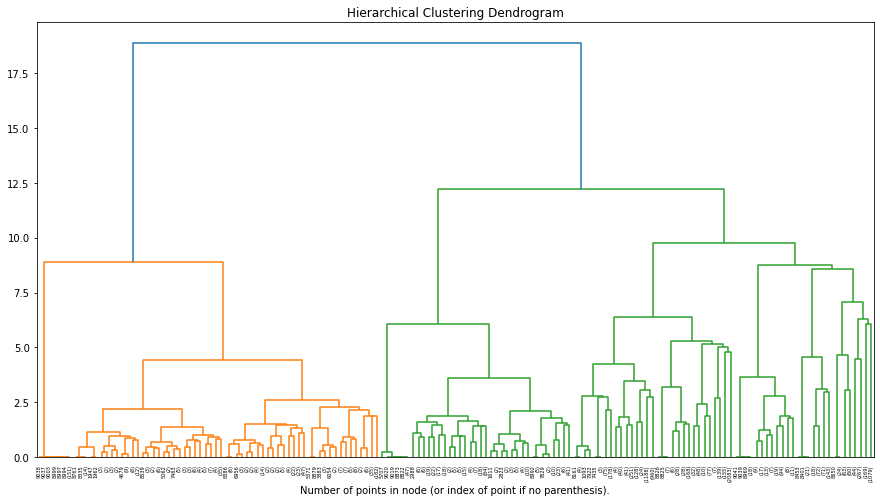

In [7]:
plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top 7 levels of the dendrogram
plot_dendrogram(model_show, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('Dendogram.png',dpi=300)
plt.show()

## Generate the top 10 venues dataframe and vuild the folium maps for the hierarchical model

In [13]:
range_i = list(range(1,model.labels_.max()+2))
df_clusters = []
df_clusters_stats = []
top_ten = []
for cluster in range_i:
    df_clusters.append(campsite_grouped[campsite_grouped['Agg_Cluster_Labels'] == cluster-1])
    cols = (df_clusters[-1] != 0).any()
    df_clusters[-1] = df_clusters[-1][cols[cols].index]
    try:
        df_clusters_stats.append(df_clusters[-1].drop(['Agg_Cluster_Labels'],1).describe().T.sort_values(by='mean', ascending=False))
    except:
        df_clusters_stats.append(df_clusters[-1].describe().T.sort_values(by='mean', ascending=False))
    temp = {}
    temp['name'] = 'Cluster {}'.format(cluster-1)
    lo = 0
    for top in df_clusters_stats[-1].iloc[:10].reset_index()['index'].tolist():
        lo = lo+1
        temp[str(lo)] = top
    top_ten.append(temp)
    print(cluster)
df_top_ten = pd.DataFrame(top_ten).set_index(['name'])
df_top_ten

1
2
3
4
5
6


,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Construction & Landscaping,State / Provincial Park,Park,Beach,Scenic Lookout,Golf Course,Trail,Lake,River
Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Pizza Place,Gas Station,Sandwich Place,Discount Store,Grocery Store,Campground
Cluster 2,Lake,Campground,Harbor / Marina,State / Provincial Park,American Restaurant,Scenic Lookout,Golf Course,Convenience Store,Park,Hotel
Cluster 3,Campground,Lake,Home Service,Trail,Convenience Store,Beach,Construction & Landscaping,State / Provincial Park,Hotel,Forest
Cluster 4,Campground,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster 5,Trail,Campground,State / Provincial Park,Mountain,National Park,Tourist Information Center,Park,Food,Lake,Scenic Lookout


In [14]:
con = sqlite3.connect('Campsite_data_4k-all.db')
df_top_ten.reset_index().to_sql('Agg_top_ten',con,if_exists='replace')
con.close()

In [15]:
# create map of RV parks using latitude and longitude values
latitude = df_RV['Latitude'].mean()
longitude = df_RV['Longitude'].mean()
map_national_RV_parks_clusters = {}
for cluster in df_RV.groupby('Agg_Cluster_Labels').count().reset_index()['Agg_Cluster_Labels'].tolist():
    
    map_national_RV_parks_clusters[cluster] = folium.Map(location=[latitude, longitude], zoom_start=4)

    # add markers to map
    marker_cluster_clusters = {}
    marker_cluster_clusters[cluster] = folium.plugins.MarkerCluster().add_to(map_national_RV_parks_clusters[cluster])
    for lat, lng, name in zip(df_RV[df_RV['Agg_Cluster_Labels']==cluster]['Latitude'], df_RV[df_RV['Agg_Cluster_Labels']==cluster]['Longitude'], df_RV.reset_index()[df_RV['Agg_Cluster_Labels']==cluster]['Campsite_Name']):
        alphanumeric = [character for character in name if character.isalnum()]
        name = "".join(alphanumeric)
        label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
        #label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster_clusters[cluster])  

    map_national_RV_parks_clusters[cluster].save('Agg/Cluster_{}.html'.format(int(cluster)))

# Comparing the two models

In [2]:
import pandas as pd
import sqlite3
import requests
import numpy as np
import folium
import folium.plugins 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
import tabulate

In [7]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT A.Latitude, A.Longitude, A.Campsite_Name, Agg_Cluster_Labels, Kmeans_Cluster_Labels FROM Agg A, Kmeans K where A.Latitude = K.Latitude'''
df_RV = pd.read_sql_query(query,con)

In [13]:
#df_RV = df_RV.fillna(12)
df_RV = df_RV.dropna()

In [14]:
range_i = list(range(1,int(df_RV['Agg_Cluster_Labels'].max()+2)))
df_clusters = []
for cluster in range_i:
    df_clusters.append(df_RV[df_RV['Agg_Cluster_Labels'] == cluster-1])

In [15]:
df_clusters[0]

,Latitude,Longitude,Campsite_Name,Agg_Cluster_Labels,Kmeans_Cluster_Labels
3,44.350050,-76.054170,1000 Islands Camping Resort,0.0,0.0
11,34.560453,-85.552682,1776 RV and Campground,0.0,1.0
15,39.347457,-87.911546,21 Guns Campgrounds,0.0,3.0
17,44.068518,-102.449284,24 Express Campground,0.0,1.0
26,37.819286,-83.723770,4 Guys RV Park at the Gorge,0.0,0.0
...,...,...,...,...,...
15540,38.970887,-105.344306,Travel Port Campground,0.0,0.0
15541,48.816170,-87.270614,Travel Rest Tent and Trailer Park,0.0,1.0
15548,31.751306,-98.921703,Travelers N Park and Campground,0.0,1.0
16673,46.219760,-119.783936,Wine Country RV Park,0.0,3.0


In [16]:
cluster_stats = []
for cluster in df_clusters:
    temp = {}
    temp['Cluster'] = str(int(cluster['Agg_Cluster_Labels'].mean()))
    for i in range_i:
        temp[str(i-1)] = cluster[cluster['Kmeans_Cluster_Labels'] == i-1]['Kmeans_Cluster_Labels'].count()
    cluster_stats.append(temp)

In [17]:
df_cluster_stats = pd.DataFrame(cluster_stats).set_index('Cluster')
df_cluster_stats

,0,1,2,3,4,5
Cluster,,,,,,
0,531,978,168,352,24,10
1,250,5262,60,142,24,0
2,16,108,8,3,266,0
3,395,6,15,4,37,90
4,0,0,0,0,0,160
5,2,12,182,6,0,0


We would ideally like to see al lthe values run down the diagonal so that the relative groups can have the same labels. Currently the numbers of the groups between the two tests don't match

In [21]:
relabel_groups_list=[]
for i in df_cluster_stats.columns:
    relabel_groups_list.append(int(df_cluster_stats[df_cluster_stats[i].max() == df_cluster_stats[i]].reset_index()['Cluster'].values))

In [22]:
#relabel_groups_list[7]=9
relabel_groups_list[3]=3
relabel_groups_list

[0, 1, 5, 3, 2, 4]

In [23]:
df_RV['new_Kmeans_labels'] = df_RV['Kmeans_Cluster_Labels'].map(lambda x:relabel_groups_list[int(x)])

In [24]:
df_RV

,Latitude,Longitude,Campsite_Name,Agg_Cluster_Labels,Kmeans_Cluster_Labels,new_Kmeans_labels
0,55.249428,-127.679933,'KSAN Historical Village Campground,1.0,1.0,1
1,44.030277,-73.403468,10 Acres Campground and RV Park,1.0,1.0,1
2,44.276788,-75.997158,1000 Islands Campground,1.0,1.0,1
3,44.350050,-76.054170,1000 Islands Camping Resort,0.0,0.0,0
4,43.891877,-76.216943,1000 Islands/Association Island K O A,1.0,1.0,1
...,...,...,...,...,...,...
16443,39.200483,-107.231685,White River NF - Redstone Campground,1.0,3.0,3
16673,46.219760,-119.783936,Wine Country RV Park,0.0,3.0,3
16674,46.219760,-119.783936,Wine Country RV Park,0.0,3.0,3
16714,43.311713,-94.704401,Wolden County Recreation Area and Campground,1.0,1.0,1


In [25]:
df_RV.groupby('Agg_Cluster_Labels').count().sum()[0]

9111

In [26]:
range_i = list(range(1,int(df_RV['Agg_Cluster_Labels'].max()+2)))
df_clusters = []
for cluster in range_i:
    df_clusters.append(df_RV[df_RV['Agg_Cluster_Labels'] == cluster-1])
cluster_stats = []

for cluster in df_clusters:
    temp = {}
    temp['Cluster'] = str(int(cluster['Agg_Cluster_Labels'].mean()))
    for i in range_i:
        temp[str(i-1)] = int(cluster[cluster['new_Kmeans_labels'] == i-1]['new_Kmeans_labels'].count())
    temp['Total'] = df_RV.groupby('Agg_Cluster_Labels').count().loc[int(cluster['Agg_Cluster_Labels'].mean())][0]
    cluster_stats.append(temp)
    
temp={}
temp['Cluster']='Total'
temp['Total'] = df_RV.groupby('Agg_Cluster_Labels').count().sum()[0]
for row in df_RV.groupby('new_Kmeans_labels').count().iterrows():
    temp[str(row[0])]=row[1][1]
cluster_stats.append(temp)

df_cluster_stats = pd.DataFrame(cluster_stats).set_index('Cluster')
df_cluster_stats

,0,1,2,3,4,5,Total
Cluster,,,,,,,
0,531,978,24,352,10,168,2063
1,250,5262,24,142,0,60,5738
2,16,108,266,3,0,8,401
3,395,6,37,4,90,15,547
4,0,0,0,0,160,0,160
5,2,12,0,6,0,182,202
Total,1194,6366,351,507,260,433,9111


In [27]:
df_cluster_stats.iloc[-1][5]

433

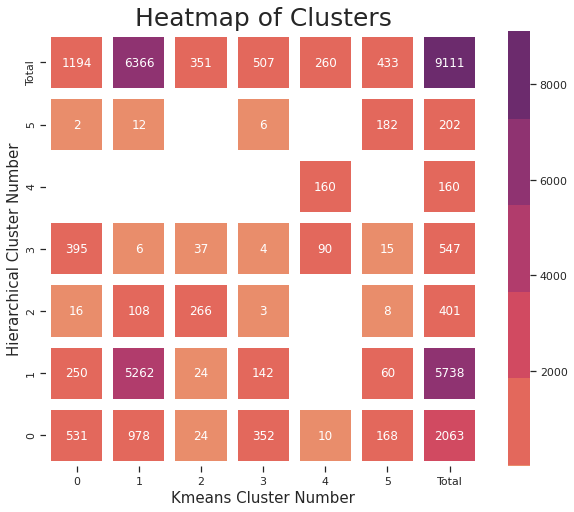

In [33]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8)), plt.axes()
cmap = sns.color_palette("flare")#sns.color_palette("light:#5A9", as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_cluster_stats[df_cluster_stats.columns.tolist()].replace({0:np.nan}),
            annot=True,linewidths=10,
            square=True,
            center=3650,
            fmt='.0f',
            cmap = cmap).invert_yaxis() #400 635
plt.title('Heatmap of Clusters', fontsize = 25) # title with fontsize 20
plt.xlabel('Kmeans Cluster Number', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Hierarchical Cluster Number', fontsize = 15) # y-axis label with fontsize 15
plt.savefig('Agg_Kmeans_corr.png',dpi=500)
plt.show()

The shift from the agreed upon group or better the agreement with the total number of places in that group

In [34]:
def return_totalOr(cluster):
    score = 0
    for row in df_RV.iterrows():
        #if score < 1:
            #print(row[1][5])
        if row[1][3]==i or row[1][5]==i:
            score = score +1
    return score

agreement_scores =[]
for i in list(map(lambda x:x-1,range(1,int(df_RV['Kmeans_Cluster_Labels'].max())+2))):
    temp= {}
    temp['Name'] = 'Cluster {}'.format(i)
    temp['Agreed'] = df_cluster_stats.iloc[i][i]
    temp['Total Hierarchical'] = df_cluster_stats.iloc[i][-1]
    temp['Total Kmeans'] = df_cluster_stats.iloc[-1][i]
    temp['Agreed Score (Hier.)'] = int(temp['Agreed']/temp['Total Hierarchical']*1000)/10
    temp['Agreed Score (Kmeans)'] = int(temp['Agreed']/temp['Total Kmeans']*1000)/10
    temp['Total in either model'] = return_totalOr(i)
    temp['Total Score (Hier.)'] = int(temp['Total Hierarchical']/temp['Total in either model']*1000)/10
    temp['Total Score (Kmeans)'] = int(temp['Total Kmeans']/temp['Total in either model']*1000)/10
    temp['Dominant'] = (lambda x: "Kmeans" if x>temp['Agreed Score (Hier.)'] else 'Hierarchical')(temp['Agreed Score (Kmeans)'])
    agreement_scores.append(temp)

df_scores = pd.DataFrame(agreement_scores).set_index('Name')
print(df_scores.to_markdown())
df_scores

| Name      |   Agreed |   Total Hierarchical |   Total Kmeans |   Agreed Score (Hier.) |   Agreed Score (Kmeans) |   Total in either model |   Total Score (Hier.) |   Total Score (Kmeans) | Dominant     |
|:----------|---------:|---------------------:|---------------:|-----------------------:|------------------------:|------------------------:|----------------------:|-----------------------:|:-------------|
| Cluster 0 |      531 |                 2063 |           1194 |                   25.7 |                    44.4 |                    2726 |                  75.6 |                   43.8 | Kmeans       |
| Cluster 1 |     5262 |                 5738 |           6366 |                   91.7 |                    82.6 |                    6842 |                  83.8 |                   93   | Hierarchical |
| Cluster 2 |      266 |                  401 |            351 |                   66.3 |                    75.7 |                     486 |                  82.5 |           

,Agreed,Total Hierarchical,Total Kmeans,Agreed Score (Hier.),Agreed Score (Kmeans),Total in either model,Total Score (Hier.),Total Score (Kmeans),Dominant
Name,,,,,,,,,
Cluster 0,531,2063,1194,25.7,44.4,2726,75.6,43.8,Kmeans
Cluster 1,5262,5738,6366,91.7,82.6,6842,83.8,93.0,Hierarchical
Cluster 2,266,401,351,66.3,75.7,486,82.5,72.2,Kmeans
Cluster 3,4,547,507,0.7,0.7,1050,52.0,48.2,Hierarchical
Cluster 4,160,160,260,100.0,61.5,260,61.5,100.0,Hierarchical
Cluster 5,182,202,433,90.0,42.0,453,44.5,95.5,Hierarchical


In [35]:
df_scores.describe()

,Agreed,Total Hierarchical,Total Kmeans,Agreed Score (Hier.),Agreed Score (Kmeans),Total in either model,Total Score (Hier.),Total Score (Kmeans)
count,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000
mean,1067.500000,1518.500000,1518.500000,62.400000,51.15000,1969.500000,66.650000,75.450000
std,2062.171841,2185.038833,2397.994058,40.504321,29.57504,2552.722605,16.475527,24.769154
min,4.000000,160.000000,260.000000,0.700000,0.70000,260.000000,44.500000,43.800000
25%,165.500000,251.750000,371.500000,35.850000,42.60000,461.250000,54.375000,54.200000
50%,224.000000,474.000000,470.000000,78.150000,52.95000,768.000000,68.550000,82.600000
75%,464.750000,1684.000000,1022.250000,91.275000,72.15000,2307.000000,80.775000,94.875000
max,5262.000000,5738.000000,6366.000000,100.000000,82.60000,6842.000000,83.800000,100.000000


In [36]:
df_scores['Agreed'].sum()

6405

In [37]:
print(df_cluster_stats.to_markdown())

| Cluster   |    0 |    1 |   2 |   3 |   4 |   5 |   Total |
|:----------|-----:|-----:|----:|----:|----:|----:|--------:|
| 0         |  531 |  978 |  24 | 352 |  10 | 168 |    2063 |
| 1         |  250 | 5262 |  24 | 142 |   0 |  60 |    5738 |
| 2         |   16 |  108 | 266 |   3 |   0 |   8 |     401 |
| 3         |  395 |    6 |  37 |   4 |  90 |  15 |     547 |
| 4         |    0 |    0 |   0 |   0 | 160 |   0 |     160 |
| 5         |    2 |   12 |   0 |   6 |   0 | 182 |     202 |
| Total     | 1194 | 6366 | 351 | 507 | 260 | 433 |    9111 |


In [40]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT * FROM Agg_top_ten'''
df_Agg_top_ten = pd.read_sql_query(query,con).drop('index',axis=1).set_index('name')
query = ''' SELECT * FROM Kmeans_top_ten   '''
df_Kmeans_top_ten = pd.read_sql_query(query,con).drop('index',axis=1).set_index('name')
con.close()

In [41]:
df_Kmeans_top_ten

,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Lake,Park,State / Provincial Park,Beach,Scenic Lookout,American Restaurant,Convenience Store,Harbor / Marina,Golf Course
Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Gas Station,Pizza Place,Sandwich Place,Discount Store,Grocery Store,Coffee Shop
Cluster 2,Trail,Campground,Scenic Lookout,State / Provincial Park,Lake,Park,Mountain,National Park,American Restaurant,Beach
Cluster 3,Construction & Landscaping,Campground,Home Service,Lake,Business Service,Golf Course,Gas Station,Restaurant,Grocery Store,Trail
Cluster 4,Lake,Campground,State / Provincial Park,Harbor / Marina,American Restaurant,Convenience Store,Park,Scenic Lookout,Golf Course,Beach
Cluster 5,Campground,Lake,Home Service,Trail,State / Provincial Park,Construction & Landscaping,Boat or Ferry,Beach,Hotel,Diner


In [42]:
rearrange_list = []
for i in list(map(lambda x:x-1,range(1,np.array(relabel_groups_list).max()+2))):
    temp =df_Kmeans_top_ten.iloc[relabel_groups_list[i]].to_dict()
    temp['name'] = 'Cluster {}'.format(i)
    rearrange_list.append(temp)
df_Kmeans_top_ten = pd.DataFrame(rearrange_list).set_index('name')
df_Kmeans_top_ten

,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Lake,Park,State / Provincial Park,Beach,Scenic Lookout,American Restaurant,Convenience Store,Harbor / Marina,Golf Course
Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Gas Station,Pizza Place,Sandwich Place,Discount Store,Grocery Store,Coffee Shop
Cluster 2,Campground,Lake,Home Service,Trail,State / Provincial Park,Construction & Landscaping,Boat or Ferry,Beach,Hotel,Diner
Cluster 3,Construction & Landscaping,Campground,Home Service,Lake,Business Service,Golf Course,Gas Station,Restaurant,Grocery Store,Trail
Cluster 4,Trail,Campground,Scenic Lookout,State / Provincial Park,Lake,Park,Mountain,National Park,American Restaurant,Beach
Cluster 5,Lake,Campground,State / Provincial Park,Harbor / Marina,American Restaurant,Convenience Store,Park,Scenic Lookout,Golf Course,Beach


In [43]:
df_Agg_top_ten

,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Construction & Landscaping,State / Provincial Park,Park,Beach,Scenic Lookout,Golf Course,Trail,Lake,River
Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Pizza Place,Gas Station,Sandwich Place,Discount Store,Grocery Store,Campground
Cluster 2,Lake,Campground,Harbor / Marina,State / Provincial Park,American Restaurant,Scenic Lookout,Golf Course,Convenience Store,Park,Hotel
Cluster 3,Campground,Lake,Home Service,Trail,Convenience Store,Beach,Construction & Landscaping,State / Provincial Park,Hotel,Forest
Cluster 4,Campground,None,None,None,None,None,None,None,None,None
Cluster 5,Trail,Campground,State / Provincial Park,Mountain,National Park,Tourist Information Center,Park,Food,Lake,Scenic Lookout


In [45]:
compare_venues_list =[]
agg_venues=[]
for i in list(map(lambda x:x-1,range(1,int(df_RV['Kmeans_Cluster_Labels'].max())+2))):
    temp =df_Kmeans_top_ten.reset_index().iloc[i].to_dict()
    temp['name'] = 'Kmeans: {}'.format(temp['name'])
    compare_venues_list.append(temp)
    temp =df_Agg_top_ten.reset_index().iloc[i].to_dict()
    temp['name'] = 'Hierarchical: {}'.format(temp['name'])
    compare_venues_list.append(temp)
    agg_venues.append(temp)

df_compare_top_5 = pd.DataFrame(compare_venues_list).set_index('name').iloc[:,:5]

In [46]:
df_compare_top_5

,1,2,3,4,5
name,,,,,
Kmeans: Cluster 0,Campground,Lake,Park,State / Provincial Park,Beach
Hierarchical: Cluster 0,Campground,Construction & Landscaping,State / Provincial Park,Park,Beach
Kmeans: Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Gas Station
Hierarchical: Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Pizza Place
Kmeans: Cluster 2,Campground,Lake,Home Service,Trail,State / Provincial Park
Hierarchical: Cluster 2,Lake,Campground,Harbor / Marina,State / Provincial Park,American Restaurant
Kmeans: Cluster 3,Construction & Landscaping,Campground,Home Service,Lake,Business Service
Hierarchical: Cluster 3,Campground,Lake,Home Service,Trail,Convenience Store
Kmeans: Cluster 4,Trail,Campground,Scenic Lookout,State / Provincial Park,Lake


In [47]:
df_compare_top_5

,1,2,3,4,5
name,,,,,
Kmeans: Cluster 0,Campground,Lake,Park,State / Provincial Park,Beach
Hierarchical: Cluster 0,Campground,Construction & Landscaping,State / Provincial Park,Park,Beach
Kmeans: Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Gas Station
Hierarchical: Cluster 1,American Restaurant,Fast Food Restaurant,Hotel,Convenience Store,Pizza Place
Kmeans: Cluster 2,Campground,Lake,Home Service,Trail,State / Provincial Park
Hierarchical: Cluster 2,Lake,Campground,Harbor / Marina,State / Provincial Park,American Restaurant
Kmeans: Cluster 3,Construction & Landscaping,Campground,Home Service,Lake,Business Service
Hierarchical: Cluster 3,Campground,Lake,Home Service,Trail,Convenience Store
Kmeans: Cluster 4,Trail,Campground,Scenic Lookout,State / Provincial Park,Lake


In [48]:
df_temp = df_compare_top_5.reset_index()
print(pd.DataFrame(agg_venues).set_index('name').iloc[:,:5].to_markdown())

| name                    | 1                   | 2                          | 3                       | 4                       | 5                   |
|:------------------------|:--------------------|:---------------------------|:------------------------|:------------------------|:--------------------|
| Hierarchical: Cluster 0 | Campground          | Construction & Landscaping | State / Provincial Park | Park                    | Beach               |
| Hierarchical: Cluster 1 | American Restaurant | Fast Food Restaurant       | Hotel                   | Convenience Store       | Pizza Place         |
| Hierarchical: Cluster 2 | Lake                | Campground                 | Harbor / Marina         | State / Provincial Park | American Restaurant |
| Hierarchical: Cluster 3 | Campground          | Lake                       | Home Service            | Trail                   | Convenience Store   |
| Hierarchical: Cluster 4 | Campground          |                            |    

In [49]:
def compareClusters(x,y):
    if x==y:
        return x
    else:
        return np.nan
    
agreed_list=[]
    
for row in df_RV.iterrows():
    temp = row[1].to_dict()
    temp['Agreed'] = compareClusters(temp['new_Kmeans_labels'],temp['Agg_Cluster_Labels'])
    agreed_list.append(temp)
    
df_agreed = pd.DataFrame(agreed_list).dropna().reset_index().drop('index',1)

In [52]:
# create map of RV parks using latitude and longitude values
latitude = df_agreed['Latitude'].mean()
longitude = df_agreed['Longitude'].mean()
map_national_RV_parks_clusters = {}
for cluster in df_agreed.groupby('Agg_Cluster_Labels').count().reset_index()['Agg_Cluster_Labels'].tolist():
    
    map_national_RV_parks_clusters[cluster] = folium.Map(location=[latitude, longitude], zoom_start=4)

    # add markers to map
    marker_cluster_clusters = {}
    marker_cluster_clusters[cluster] = folium.plugins.MarkerCluster().add_to(map_national_RV_parks_clusters[cluster])
    for lat, lng, name in zip(df_agreed[df_agreed['Agg_Cluster_Labels']==cluster]['Latitude'], 
                              df_agreed[df_agreed['Agg_Cluster_Labels']==cluster]['Longitude'], 
                              df_agreed.reset_index()[df_agreed['Agg_Cluster_Labels']==cluster]['Campsite_Name']):
        alphanumeric = [character for character in name if character.isalnum()]
        name = "".join(alphanumeric)
        label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
        #label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster_clusters[cluster])  

    map_national_RV_parks_clusters[cluster].save('Joined/Cluster {} from analysis.html'.format(cluster))

In [61]:
df_RV = df_RV.reset_index()

In [62]:
# create map of RV parks using latitude and longitude values
latitude = df_RV['Latitude'].mean()
longitude = df_RV['Longitude'].mean()
map_national_RV_parks_clusters = {}
for cluster in df_RV.groupby('new_Kmeans_labels').count().reset_index()['new_Kmeans_labels'].tolist():
    
    map_national_RV_parks_clusters[cluster] = folium.Map(location=[latitude, longitude], zoom_start=4)

    # add markers to map
    marker_cluster_clusters = {}
    marker_cluster_clusters[cluster] = folium.plugins.MarkerCluster().add_to(map_national_RV_parks_clusters[cluster])
    for lat, lng, name in zip(df_RV[df_RV['new_Kmeans_labels']==cluster]['Latitude'], df_RV[df_RV['new_Kmeans_labels']==cluster]['Longitude'], df_RV.reset_index()[df_RV['new_Kmeans_labels']==cluster]['Campsite_Name']):
        alphanumeric = [character for character in name if character.isalnum()]
        name = "".join(alphanumeric)
        label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
        #label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster_clusters[cluster])  

    map_national_RV_parks_clusters[cluster].save('Kmeans/Cluster_{}.html'.format(int(cluster)))

In [56]:
df_RV

,Latitude,Longitude,Campsite_Name,Agg_Cluster_Labels,Kmeans_Cluster_Labels,new_Kmeans_labels
0,55.249428,-127.679933,'KSAN Historical Village Campground,1.0,1.0,1
1,44.030277,-73.403468,10 Acres Campground and RV Park,1.0,1.0,1
2,44.276788,-75.997158,1000 Islands Campground,1.0,1.0,1
3,44.350050,-76.054170,1000 Islands Camping Resort,0.0,0.0,0
4,43.891877,-76.216943,1000 Islands/Association Island K O A,1.0,1.0,1
...,...,...,...,...,...,...
16443,39.200483,-107.231685,White River NF - Redstone Campground,1.0,3.0,3
16673,46.219760,-119.783936,Wine Country RV Park,0.0,3.0,3
16674,46.219760,-119.783936,Wine Country RV Park,0.0,3.0,3
16714,43.311713,-94.704401,Wolden County Recreation Area and Campground,1.0,1.0,1


In [67]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(df_RV['Agg_Cluster_Labels'].to_numpy(), df_RV['new_Kmeans_labels'].to_numpy())

0.4868752379707563